# Übung 3.4 a) 

Nun sollen statt der Gesamtkosten die Gesamtemissionen minimiert werden. Da der Speicher in Punkt 3.3 nicht aktiv war, gilt die folgenden Auswertungen für Punkt 2 und 3.

In [1]:
#Einlesen der Module
from pyomo.environ import *
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

T = 24
timesteps = np.arange(T)

#Zertifikatspreis
c_CO2 = 80 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
# Werte wurden auf die Angabe angepasst
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 30,
         'Gasturbine': 30} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden, PV und Wind laden
df = pd.read_excel('Last_PV_Wind.xlsx')
wind = df['Wind 300 MW']
PV = df['PV 200 MW Sommer']
load = df['Last Sommer [MW]']-df['Wind 300 MW']-df['PV 200 MW Sommer'] # Gruppe 3
#print(load)
#die Residuallast (in unserem Fall mit load definiert) entspricht der gesamten Nachfrage minus der Erzeugung aus PV und minus der Erzeugung aus Wind
#Residuallast muss von thermischen Kraftwerken gedeckt werden 

# Pyomo Modell aufstellen

model = ConcreteModel()

model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)

# Zielfunktion, Emissionen sollen minimiert werden
#dazu werden die Grenzkosten aller Kraftwerke zu jedem timestep summiert.
model.obj = Objective(
    expr = sum(model.x[n,t] * emissions[n] for n in thermalPlant for t in timesteps), 
    sense= minimize)

#Nebenbedingungen bezüglich Leistung und Last 
def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
model.load_con = Constraint(timesteps, 
                            rule = load_constraint_rule)

###Schattenvariable für Punkt c)###
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
guDPower = np.empty(T, dtype=float)
gasPower = np.empty(T, dtype=float)
kohlePower = np.empty(T, dtype=float)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value
        guDPower[t] = PowerThermal.loc[t, 'GuD']
        gasPower[t] = PowerThermal.loc[t, 'Gasturbine']
        kohlePower[t] = PowerThermal.loc[t, 'Kohle']

#Berechnung der Kosten und der gesamten Emissionen
print()
totalMinCost = sum(model.x[n,t].value * MC[n] for n in thermalPlant for t in timesteps)
print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR" )
totalEmissions = model.obj()
print("Gesamte CO2 Emissionen", totalEmissions, "tCO2" )

Model unknown

  Variables:
    x : Size=72, Index={Kohle, GuD, Gasturbine}*{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 : 40.325732899022796 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 : 26.319218241042336 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 : 14.136807817589556 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 : 14.885993485341999 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 : 23.654723127035822 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 : 33.306188925081415 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 : 115.29641693811072 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :  260.2801302931596

## b) Grafische Darstellung der Situation

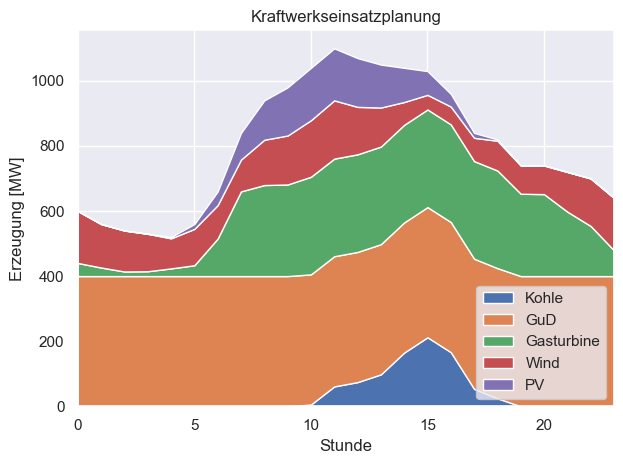

In [2]:
# plot
sns.set()
labels = ['Kohle', 'GuD', 'Gasturbine','Wind', 'PV']

fig, ax = plt.subplots()

ax.stackplot(timesteps, 
            PowerThermal.to_numpy(dtype = float).transpose(),
             wind, PV,
             labels=labels)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='lower right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlabel('Stunde')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

In der Grafik ist ersichtlich, dass die Erneuerbaren vollständig einspeisen. Die Residuallast wird zuerst von der GuD, dann von der Gasturbine und zum Abschluss von dem Kohlekraftwerk gedeckt.

## c) Änderung des CO2-Preises
Nun wird die Auswirkung des CO2-Preises und seine Auswirkungen auf die Gesamtkosten sowie Gesamtemissionen modelliert. Dazu wird das Modell für Zertifikatspreise zwischen 0 und 200 €/$t_{CO2}$ gelöst.

    CO2_price  totalMinCost  totalEmissions
0           0  4.273835e+05    11901.400090
1           5  4.868905e+05    11901.400090
2          10  5.463975e+05    11901.400090
3          15  6.059045e+05    11901.400090
4          20  6.654115e+05    11901.400090
5          25  7.249185e+05    11901.400090
6          30  7.844255e+05    11901.400090
7          35  8.439325e+05    11901.400090
8          40  9.034395e+05    11901.400090
9          45  9.629465e+05    11901.400090
10         50  1.022453e+06    11901.400090
11         55  1.077063e+06     8078.027754
12         60  1.117453e+06     8078.027754
13         65  1.157843e+06     8078.027754
14         70  1.198233e+06     8078.027754
15         75  1.238623e+06     8078.027754
16         80  1.279013e+06     8078.027754
17         85  1.319404e+06     8078.027754
18         90  1.359794e+06     8078.027754
19         95  1.400184e+06     8078.027754
20        100  1.440574e+06     8078.027754
21        105  1.480964e+06     

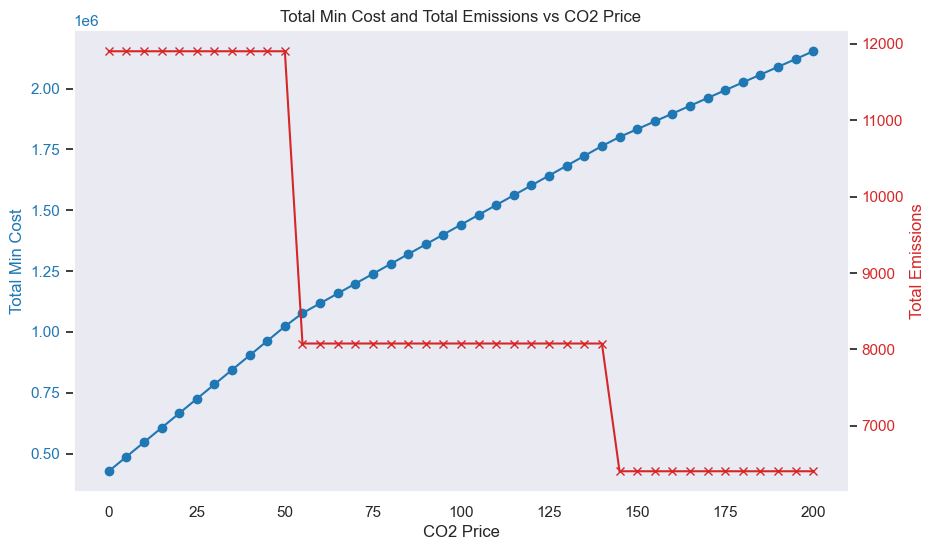

In [3]:
CO2_price = []
totalMinCost = []
totalEmissions = []
for i in range(0,201,5):
    CO2_price += [i]

for c in CO2_price:
    T = 24
    timesteps = np.arange(T)

    #Zertifikatspreis
    c_CO2 = c # EUR/tCO2

    # Marginal costs der thermischen Kraftwerke berechnen
    # Werte wurden auf die Angabe angepasst
    thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
    power = {'Kohle': 600,
            'GuD': 400,
            'Gasturbine': 300} # MW
    efficiency = {'Kohle': 0.41,
            'GuD': 0.58,
            'Gasturbine': 0.4} 
    fuel_price = {'Kohle': 10,
            'GuD': 30,
            'Gasturbine': 30} # EUR/MWhprim
    emission_factor = {'Kohle': 0.35,
            'GuD': 0.2,
            'Gasturbine': 0.2} # tCO2/MWhprim
    MC = {} # marginal costs in EUR/MWh
    emissions = {} # emissions in tCO2/MWh
    for n in thermalPlant:
        MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
        emissions[n] = emission_factor[n] / efficiency[n]
        
    # Daten laden, PV und Wind laden
    df = pd.read_excel('Last_PV_Wind.xlsx')
    wind = df['Wind 300 MW']
    PV = df['PV 200 MW Sommer']
    load = df['Last Sommer [MW]']-df['Wind 300 MW']-df['PV 200 MW Sommer'] # Gruppe 3
    #print(load)
    #die Residuallast (in unserem Fall mit load definiert) entspricht der gesamten Nachfrage minus der Erzeugung aus PV und minus der Erzeugung aus Wind
    #Residuallast muss von thermischen Kraftwerken gedeckt werden 

    # Pyomo Modell aufstellen

    model = ConcreteModel()

    model.x = Var(thermalPlant, timesteps, within = NonNegativeReals)

    # Zielfunktion, Kosten sollen minimiert werden
    #dazu werden die Grenzkosten aller Kraftwerke zu jedem timestep summiert.
    model.obj = Objective(
        expr = sum(model.x[n,t] * MC[n] for n in thermalPlant for t in timesteps), 
        sense= minimize)

    #Nebenbedingungen bezüglich Leistung und Last 
    def power_constraint_rule(model, n, t):    
        return model.x[n,t] <= power[n]
    model.power_con = Constraint(thermalPlant, 
                                timesteps, 
                                rule = power_constraint_rule)

    def load_constraint_rule(model, t):    
        return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
    model.load_con = Constraint(timesteps, 
                                rule = load_constraint_rule)

    ###Schattenvariable für Punkt c)###
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT_EXPORT)

    opt = SolverFactory('gurobi')
    opt_success = opt.solve(model)

    #model.display()

    #Berechnung der minimalen Kosten und der gesamten Emissionen
    totalMinCost += [model.obj()]
    #print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR" )
    totalEmissions += [sum(model.x[n,t].value * emissions[n] for n in thermalPlant for t in timesteps)]
    #print("Gesamte CO2 Emissionen", totalEmissions, "tCO2" )

CO2_price_results = pd.DataFrame({
    'CO2_price': CO2_price,
    'totalMinCost': totalMinCost,
    'totalEmissions': totalEmissions })
print(CO2_price_results)

fig, ax1 = plt.subplots(figsize=(10, 6), facecolor = 'white')


# Plot für totalMinCost
ax1.plot(CO2_price_results['CO2_price'], CO2_price_results['totalMinCost'], label='Total Min Cost', marker='o', color='tab:blue')
ax1.set_xlabel('CO2 Price')
ax1.set_ylabel('Total Min Cost', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(False)

# Zweite y-Achse für totalEmissions
ax2 = ax1.twinx()
ax2.plot(CO2_price_results['CO2_price'], CO2_price_results['totalEmissions'], label='Total Emissions', marker='x', color='tab:red')
ax2.set_ylabel('Total Emissions', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.grid(False)

plt.title('Total Min Cost and Total Emissions vs CO2 Price')
#fig.tight_layout()
plt.show()


## d) Gesamtemissionen 
Die Gesamtemissionen im emissionsminimierten Fall betragen 6406.8 tonnen CO2. Dieser wird ab einem Zertifikatspreis von ca. 145€/t erreicht. 